### Poisson processes:

- Model used to describe events that occur at random intervals
- Example: traffic, goals scored in a soccer game

#### Problem Covered: The World Cup Problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2. Based on this outcome:

- How confident should we be that France is the better team?

- If the same teams played again, what is the chance France would win again?

#### Poisson Model Decisions: 

Author notes these are not necessary valid but reasonable simplifications. 

- `lam` (lambda): for any team against another team there exists some unknown "goal-scoring rate" which is measured in goals per game

- `lam / 90`: Assume a goal is equally likely during any minute of the game 

- Assume a team never scores twice during the same minute (`Note: Where does this one play out?`)

#### Poisson Distribution: 

Assume the number of gioals scored in a game followsing a poisson distribution. 
- `lambda` represents goal-scoring rate
- `k` represents goals scored (in a single game)

$P(k) = \frac{\lambda^{k} * e^{-\lambda}}{k!}$

*for any non-negative value of k*

In [1]:
from scipy.stats import poisson

lam = 1.4 # assume 1.4 goals per game
dist = poisson(lam)

k = 4 # amount of goals interested in
print(f"Likelihood of {k} goals: {dist.pmf(k):.5f}")

Likelihood of 4 goals: 0.03947


In [2]:
# Build a pmf
from empiricaldist import Pmf
from numpy.typing import ArrayLike
import numpy as np
import matplotlib.pyplot as plt

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()
    
def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)
    
def make_poisson_pmf(lam: int, qs: ArrayLike) -> Pmf:
    """Make a Pmf of a Poisson distribution"""
    
    # gather probs
    ps = poisson(lam).pmf(qs)
    
    # build a pmf using ps (probs) and qs(quantities)
    pmf = Pmf(ps,qs)
    pmf.normalize()
    return pmf

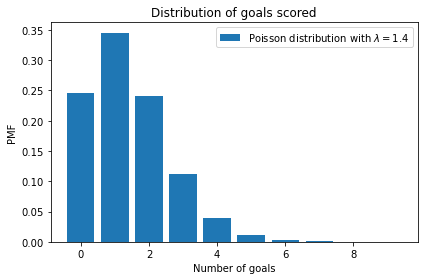

In [3]:
# Build our Pmf
lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

# Plot it out
pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')
decorate_goals('Distribution of goals scored');

#### Takeaway:

- Unsurprisingly, 0-2 are our highest likely goals scored, this aligns with a 1.4 goal rate.
- We see that higher values drop off quickly, which is expected. 

### Reversing the Problem

Given a number of goals, what can we say about the goal-scoring rate? 

#### Prior for lambda: Using Gamma Distribution 

- We know most soccer games are under 10 goals for a single team, majority under 5

- Author looks at prior world cup data and estimates 1.4 goals per game on average. This can be a starting point for prior and is used as the mean of lambda. 

    - For a good team against a bad team we expect lambda to be higher
    
    - Conversely, a bad team playing a good team likely has a lower lambda
    
#### Why use Gamma Distribution?
- Goal-scoring rate is continuous & non-negative (aligns with Gamma)

- We can get by on this problem by only considering the `alpha` term in our gamma distribution, which would be the mean of lambda. 
    - I think for standard gamma distribution the beta term is 1 which is why we can get away with only considering alpha. 
    - This looks to be what is expected in scipy notes: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
    
    - gamme is a reasonable prior to use given what we know about soccer (it is going to quickly dropoff, indicating lower rates in general have higher likelihoods)
    
- Note: This is a probability density function, so similar to cdf we can't get discrete events, but rather can densities. 

In [4]:
from scipy.stats import gamma

alpha = 1.4
qs = np.linspace(0, 10, 101) # pass in quantities to review
ps = gamma(alpha).pdf(qs) # calculate prob densities

Prior mean: 1.4140818156118378


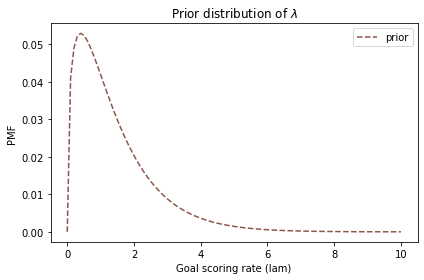

In [5]:
from empiricaldist import Pmf

# Pass into a Pmf
prior = Pmf(ps, qs)
prior.normalize()

# Note: This is a "discrete approximation" of a gamma distribution
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

prior.plot(ls='--', label='prior', color='C5')
decorate_rate(r'Prior distribution of $\lambda$');

print(f"Prior mean: {prior.mean()}")

#### What Does This Tell us?

- This distribution represents our prior knowledge about goal scoring
    - lambda is typically less than 2
    - sometimes it gets to 6, but rarely exceeds 

### The Update: 

We are given `lambda` (goal-scoring rate) and asked to compute the probability of scoring a number of goals `k`. 

Assume we have an array of possible `lambda` values - we can then compute a likelihood of the data (`goals scored`)  for each `labda`:

In [6]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

Getting the posterior is then just multiplying the priors by the likelihood

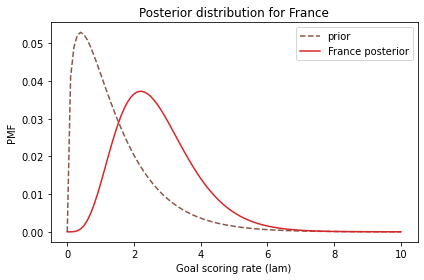

In [7]:
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data # goals scored
    lams = pmf.qs # this is a gamma distribution of lambda
    likelihood = poisson(lams).pmf(k) # pass array of lambdas in for k
    pmf *= likelihood # update
    pmf.normalize()
    
# Building posterior distribution given 4 goals were scored
france = prior.copy()
update_poisson(france, 4) # France scored 4 goals

# Plot it
prior.plot(ls='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

decorate_rate('Posterior distribution for France')

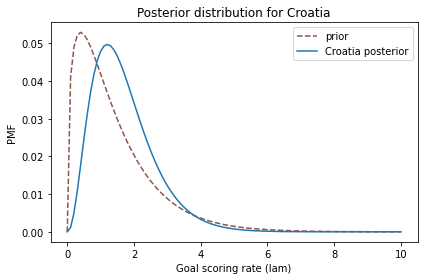

In [8]:
# Croatio had 2 goals, so how does their posterior look?
croatia = prior.copy()
update_poisson(croatia, 2)

prior.plot(ls='--', label='prior', color='C5')
croatia.plot(label='Croatia posterior', color='C0')

decorate_rate('Posterior distribution for Croatia')

In [9]:
# look at the means:
print(croatia.mean(), france.mean())

1.6999765866755225 2.699772393342308


#### Takeaways:

- Mean of croatia is shifted up slightly, makes sense since they scored two goals. 
- Mean of france shifted even more given 4 goals are scored. 

### Probability of Superiority:

How confident should we be that France is the better team? 

*Compute probability that a random value drawn from France's distribution exceeds a value drawn from Croatia's:*

- We can look across all possible combinations and determine when the quantity of france > croatia
- The likelihood of this event occurring is as simple as `p1 * p2` as that is the likelihood associated with `q1 > q2`

In [10]:
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    
    # nested for-loop is going to build all combinations 
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            
            # Anytime q1 > q2 we calculate likelihood of these qs
            # And then we add to total, which represents
            # the total likelihood of choosing q1 > q2
            if q1 > q2:
                total += p1 * p2
    return total

prob_gt(france, croatia)

0.7499366290930155

In [11]:
Pmf.prob_gt(france, croatia) # or can use the built-in method

0.7499366290930174

#### Findings:

The result is close to 75%, making us fairly comfortable saying that France is the better team - in general France will have a higher goal scored than Croatia based on posterior distribution comparisons. 

Author note: The above result assumes a fixed goal-scoring rate. Likely an unfair assumption since a team down by one goal might play more aggressively, potentially increasing both their & opponent's goal-scoring rate. 

### Predicting the Rematch: 

*If the same teams played again, what is the chance Croatia would win?*

We can solve this by generating `posterior predictive distribution`, which will represent the number of goals we expect a team to score. 


[0 1 2 3 4 5 6 7 8 9]


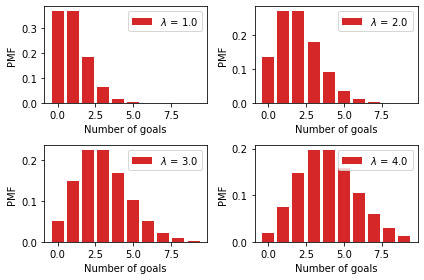

In [12]:
# Build a sequence of Pmfs based on different lambda values
print(goals)
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs]

# Plot a few different Poisson PMFs
for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    decorate_goals()

In [13]:
import pandas as pd 

def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

#### How Does Make Mixture Work here?

Walk through below:

- pmf_seq represents the 101 different distributions, pandas df:
    - each row represents a different number of goals scored (thus integer)
    - each column represents a Pmf built with a different Lambda 
        - and each value in a column represents a different probability for the associated number of goals
        - column values sum to 1
    - this represents our conditional probability: Given a lambda, what is the probability of scoring X goals
        
- we then multiply our posterior (pmf) by each likelihood value:
    - our  `pmf` object shows likelihood of lambda (101 values) for 0 - 10 in increments of 0.1
        - this is the distribution of our goal-scoring rate (really this is the posterior distribution)

So each value is actually: P(X | Lambda) * P(Lambda)
- We are accounting for the uncertainty of the lambda term now, which is how we make a prediction

- And of course sum across each row to get the likelihood of a specific event occurring:
    - This is the sum across each lambda for a single event X
    - So we look at likelihood of Scoring 1 goal with lambda 0, lamba 0.1.., lambda 1

In [14]:
# handling pmf_seq
df = pd.DataFrame(pmf_seq).fillna(0).transpose()

# confirm each col sums to 1
assert(sum(df.sum(numeric_only=True, axis=0)) == 101)

df.head()

,,,,,,,,,,,...,,,,,,,,,,
0,1.0,0.904837,0.818731,0.740818,0.670320,0.606531,0.548812,0.496585,0.449329,0.406570,...,0.000194,0.000180,0.000167,0.000155,0.000143,0.000133,0.000124,0.000115,0.000107,0.000099
1,0.0,0.090484,0.163746,0.222245,0.268128,0.303265,0.329287,0.347610,0.359463,0.365913,...,0.001770,0.001657,0.001552,0.001454,0.001363,0.001278,0.001199,0.001125,0.001056,0.000991
2,0.0,0.004524,0.016375,0.033337,0.053626,0.075816,0.098786,0.121663,0.143785,0.164661,...,0.008052,0.007621,0.007215,0.006833,0.006473,0.006133,0.005813,0.005511,0.005226,0.004957
3,0.0,0.000151,0.001092,0.003334,0.007150,0.012636,0.019757,0.028388,0.038343,0.049398,...,0.024423,0.023371,0.022368,0.021410,0.020497,0.019626,0.018795,0.018002,0.017246,0.016524
4,0.0,0.000004,0.000055,0.000250,0.000715,0.001580,0.002964,0.004968,0.007669,0.011115,...,0.055563,0.053754,0.052005,0.050315,0.048681,0.047103,0.045578,0.044105,0.042683,0.041309


In [15]:
# update
df *= np.array(france)

In [16]:
total = df.sum(axis=1)
total.head()

0    0.112030
1    0.201777
2    0.215467
3    0.177493
4    0.124612
dtype: float64

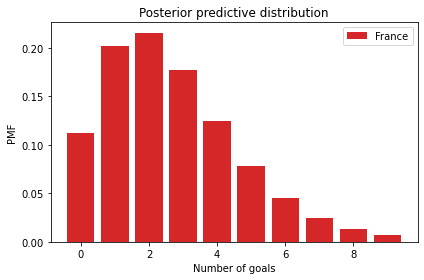

In [17]:
Pmf(total).bar(color='C3', label='France')
decorate_goals('Posterior predictive distribution')

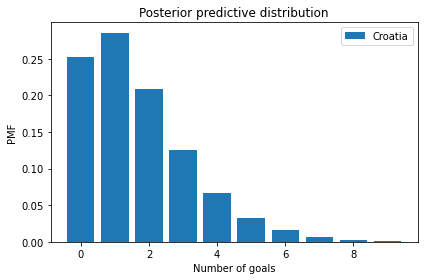

In [18]:
pred_croatia = make_mixture(croatia, pmf_seq)
pred_croatia.bar(color='C0', label='Croatia')
decorate_goals('Posterior predictive distribution');

#### Posterior Predictive Distribution: 

- It differs from our posterior as the posterior we made before is only accounting for a single parameter, such as a single lambda
- The PPD is going to consider a sequence of poisson PMFs, and these get weighted by the posterior
- Based on this, we get a distribution of goal-scoring that takes into account evidence (goals scored in prior game) and general likelihood (various lambda distributions) and spits out a marginal distribution of goals scored averaged across various lambdas. 


#### Solving our Problem

We can compare these posterior distributions in the same way as shown before, looking at how often France quantity (goals scored) > Croatia. 
- Additionally, we need to consider ties!
- Not sure why we omitted this previously

In [19]:
# build france
pred_france = make_mixture(france, pmf_seq)
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934519

In [20]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26443376257235873

In [21]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418947

In [22]:
# Total win: assume France wins half of ties:
win + tie/2

0.6529592395105466

#### What if we use a uniform prior? 

This is really just for my own handling of what the predictive posterior is showing us: 
- It takes into account the data we have seen (our posterior) almost as a weight for the sequence of Poisson distributions
- When we have a uniform distribution of lambda (our data shows each lambda is possible) we get almost a uniform posterior predictive distribution. The nature of poisson Pmf means we won't get exact uniform posterior predictive


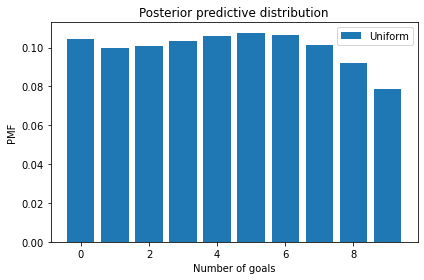

In [23]:
# build uniform distribution of lambda:
qs = np.linspace(0, 10, 101)
uni = Pmf.from_seq(qs)
pred_uni = make_mixture(uni, pmf_seq)
pred_uni.bar(color='C0', label='Uniform')
decorate_goals('Posterior predictive distribution');